##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [1]:
%pip install pandas 
%pip install matplotlib
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 
%pip install imblearn
%pip install sklearn
%pip install tensorflow
%pip install keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime as dt

from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.compose import make_column_transformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import chi2, f_classif, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, f1_score, ConfusionMatrixDisplay, mean_squared_error, accuracy_score, precision_score
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
df = pd.read_parquet("./data/catB_train.parquet", engine='pyarrow')
df.info()

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 's

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .parquet file inside that. A relative path *must* be used when loading data into pandas

In [2]:
# Can have as many cells as you want for code
import pandas as pd
filepath = "./data/catB_train.parquet" 
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.



## Part 1 Data Cleaning

In [3]:
# changes None type to NaN values
df = df.fillna(value=np.nan)
df.head()

,clntnum,race_desc,ctrycode_desc,clttype,stat_flag,min_occ_date,cltdob_fix,cltsex_fix,flg_substandard,flg_is_borderline_standard,...,recency_giclaim,giclaim_cnt_success,recency_giclaim_success,giclaim_cnt_unsuccess,recency_giclaim_unsuccess,flg_gi_claim_29d435_ever,flg_gi_claim_058815_ever,flg_gi_claim_42e115_ever,flg_gi_claim_856320_ever,f_purchase_lh
19550,91b546e924,Chinese,Singapore,P,ACTIVE,2017-10-31,1974-05-09,Female,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4600,896bae548c,Chinese,Singapore,P,ACTIVE,2007-05-23,1979-11-11,Male,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13337,f364439ae6,Others,Singapore,P,ACTIVE,2019-08-31,1976-01-28,Male,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15074,70f319cfe1,Chinese,Singapore,P,ACTIVE,2021-10-18,1976-03-19,Female,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19724,2647a81328,Chinese,Singapore,P,ACTIVE,2018-07-20,1995-07-31,Female,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# removing columns with 100% missing data (NaN values)
df = df.dropna(axis=1, how = 'all')
df.info()

# removing columns with only one unique value
unique_counts = df.nunique(axis=0, dropna=False)
columns_to_drop = unique_counts[unique_counts <= 1].index
df = df.drop(columns=columns_to_drop)
df.info()
df.head()

#dropping clntnum as it does not help with prediction
df=df.drop(columns = 'clntnum')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17992 entries, 19550 to 15795
Columns: 296 entries, clntnum to f_purchase_lh
dtypes: float64(44), int64(46), object(206)
memory usage: 40.8+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17992 entries, 19550 to 15795
Columns: 247 entries, clntnum to f_purchase_lh
dtypes: float64(44), int64(39), object(164)
memory usage: 34.0+ MB


In [5]:
#Further data cleaning for columns with only 1 real value and 1 Nan value
uni_counts = df.nunique(axis = 0)

cols = uni_counts[uni_counts <= 1]
colsdrop=[]
for i in cols.index:
  colsdrop.append(i)
  print(i, df[i].unique())
#Further data discovery shows that the clients never bought insurance
#ltc_1280bf,inv_dcd836,lh_d0adeb,32c74c so they are irrelevant and to be removed.
df=df.drop(columns=colsdrop[2:10])
print(colsdrop)
df

is_dependent_in_at_least_1_policy [ 0. nan]
f_ever_declined_la [nan  1.]
lapse_ape_ltc_1280bf [Decimal('0.00') nan]
lapse_ape_inv_dcd836 [Decimal('0.00') nan]
lapse_ape_lh_d0adeb [Decimal('0.00') nan]
lapse_ape_32c74c [Decimal('0.00') nan]
n_months_since_lapse_ltc_1280bf ['9999' nan]
n_months_since_lapse_inv_dcd836 ['9999' nan]
n_months_since_lapse_lh_d0adeb ['9999' nan]
n_months_since_lapse_32c74c ['9999' nan]
flg_affconnect_show_interest_ever [nan  1.]
flg_affconnect_ready_to_buy_ever [nan  1.]
flg_hlthclaim_839f8a_ever [nan  1.]
flg_hlthclaim_14cb37_ever [nan  1.]
f_purchase_lh [nan  1.]
['is_dependent_in_at_least_1_policy', 'f_ever_declined_la', 'lapse_ape_ltc_1280bf', 'lapse_ape_inv_dcd836', 'lapse_ape_lh_d0adeb', 'lapse_ape_32c74c', 'n_months_since_lapse_ltc_1280bf', 'n_months_since_lapse_inv_dcd836', 'n_months_since_lapse_lh_d0adeb', 'n_months_since_lapse_32c74c', 'flg_affconnect_show_interest_ever', 'flg_affconnect_ready_to_buy_ever', 'flg_hlthclaim_839f8a_ever', 'flg_hlthclaim

,race_desc,ctrycode_desc,clttype,stat_flag,min_occ_date,cltdob_fix,cltsex_fix,flg_substandard,flg_is_borderline_standard,flg_is_revised_term,...,recency_hlthclaim_success,hlthclaim_cnt_unsuccess,recency_hlthclaim_unsuccess,flg_hlthclaim_839f8a_ever,recency_hlthclaim_839f8a,flg_hlthclaim_14cb37_ever,recency_hlthclaim_14cb37,giclaim_amt,recency_giclaim,f_purchase_lh
19550,Chinese,Singapore,P,ACTIVE,2017-10-31,1974-05-09,Female,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4600,Chinese,Singapore,P,ACTIVE,2007-05-23,1979-11-11,Male,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13337,Others,Singapore,P,ACTIVE,2019-08-31,1976-01-28,Male,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15074,Chinese,Singapore,P,ACTIVE,2021-10-18,1976-03-19,Female,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19724,Chinese,Singapore,P,ACTIVE,2018-07-20,1995-07-31,Female,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,NaN,Singapore,P,LAPSED,2016-08-01,1994-05-24,Male,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11964,Chinese,Singapore,P,ACTIVE,1990-03-20,1948-12-16,Male,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5390,Chinese,Singapore,P,ACTIVE,2007-12-31,1967-12-06,Female,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
860,Others,Singapore,P,ACTIVE,2007-09-01,1986-04-01,Male,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#Data cleaning to change Nan to their respective categorical variables
for i in colsdrop:
  if i not in colsdrop[2:10]:
    if i == 'is_dependent_in_at_least_1_policy':
      df[i]=df[i].fillna(1)
    else:
      df[i]=df[i].fillna(0)

print(df["f_purchase_lh"]) # to check

df['f_purchase_lh'].unique()

19550    0.0
4600     0.0
13337    0.0
15074    0.0
19724    0.0
        ... 
11284    0.0
11964    0.0
5390     0.0
860      0.0
15795    0.0
Name: f_purchase_lh, Length: 17992, dtype: float64


array([0., 1.])

In [7]:
# Checking for all columns with NA values and assigning them to numerical or categorical
y = df.isna().sum()
nacol = y[y != 0].index

categorical, numerical = [], []

for i in nacol:
  nonull = df[i].unique()[~pd.isnull(df[i].unique())]
  try:
    x = int(nonull[0])

  except:
    x = 'lol'
  if type(x) == int and (np.all(nonull!=np.array([0.0,1.0])) and np.all(nonull!=np.array([1.0,0.0]))):
    numerical.append(i)
  else:
    categorical.append(i)

numerical.remove("hh_size_est")
categorical.append("hh_size_est")

/var/folders/nk/3csp0q8n1215gpyq8xxqzksc0000gn/T/ipykernel_2495/1752481318.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if type(x) == int and (np.all(nonull!=np.array([0.0,1.0])) and np.all(nonull!=np.array([1.0,0.0]))):


In [8]:
#Creating imputation methods
skew_values = list(df[numerical].skew(axis=0,skipna=True).values)
type(skew_values[0])


imputer = SimpleImputer(strategy='most_frequent', missing_values=np.nan)
imputer = imputer.fit(df[categorical])
df[categorical] = imputer.transform(df[categorical])

imputer2 = SimpleImputer(strategy='mean', missing_values=np.nan)
imputer3 = SimpleImputer(strategy='median', missing_values=np.nan)

#Depending on how skewed the numerical data is, different imputation methods are used
for i in range(len(skew_values)):
  if skew_values[i] > 1 or skew_values[i]<-1:
    imputer3 = imputer3.fit(df[numerical[i]].values.reshape(-1,1))
    df[numerical[i]] = imputer3.transform(df[numerical[i]].values.reshape(-1,1))
  else:
    imputer2 = imputer2.fit(df[numerical[i]].values.reshape(-1,1))
    df[numerical[i]] = imputer2.transform(df[numerical[i]].values.reshape(-1,1))

df[numerical].isna().sum()

hh_20                          0
pop_20                         0
hh_size                        0
recency_lapse                  0
recency_cancel                 0
                              ..
recency_hlthclaim_unsuccess    0
recency_hlthclaim_839f8a       0
recency_hlthclaim_14cb37       0
giclaim_amt                    0
recency_giclaim                0
Length: 62, dtype: int64

In [9]:
df[categorical].isna().sum()

race_desc                     0
ctrycode_desc                 0
cltsex_fix                    0
flg_substandard               0
flg_is_borderline_standard    0
flg_is_revised_term           0
flg_is_rental_flat            0
flg_has_health_claim          0
flg_has_life_claim            0
flg_gi_claim                  0
flg_is_proposal               0
flg_with_preauthorisation     0
flg_is_returned_mail          0
is_consent_to_mail            0
is_consent_to_email           0
is_consent_to_call            0
is_consent_to_sms             0
is_valid_dm                   0
is_valid_email                0
is_housewife_retiree          0
is_sg_pr                      0
is_class_1_2                  0
annual_income_est             0
lapse_ape_grp_de05ae          0
flg_affconnect_lapse_ever     0
hh_size_est                   0
dtype: int64

## Part 2 Data Manipulation and Preprocessing

In [10]:
#Checking the presence of None Values in DataFrame
for i in df.columns:
  if 'None' in df[i].unique():
    print(i)
print(df['min_occ_date'][df['min_occ_date']=='None'].count())
print(df['cltdob_fix'][df['cltdob_fix']=='None'].count())
#Since the number of rows with None values is small, we will just remove the rows

drop_row1= df.query("min_occ_date == 'None'")
drop_row2= df.query("cltdob_fix == 'None'")

y= pd.concat([drop_row1, drop_row2]).drop_duplicates().index
df = df.drop(y)
#Checking if successfully dropped
print(df['min_occ_date'][df['min_occ_date']=='None'].count())
print(df['cltdob_fix'][df['cltdob_fix']=='None'].count())

min_occ_date
cltdob_fix
10
22
0
0


/var/folders/nk/3csp0q8n1215gpyq8xxqzksc0000gn/T/ipykernel_2495/2145620889.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'None' in df[i].unique():


In [11]:
#converting min_occ_date and cltdob_fix to datetime format
df['min_occ_date']=pd.to_datetime(df['min_occ_date'])
df['cltdob_fix']=pd.to_datetime(df['cltdob_fix'])

df['years passed']= 2024- df['min_occ_date'].dt.year
df['age']= 2024- df['cltdob_fix'].dt.year

df=df.drop(columns=['min_occ_date','cltdob_fix'])

In [12]:
#Creating columns with the total sum of premiums
ape_list =[i for i in df.columns if i.startswith('ape_')]
sum_ins_list=[i for i in df.columns if i.startswith('sumins')]
prempaid_list=[i for i in df.columns if i.startswith('prempaid')]
df['total_ape']=df[ape_list].sum(axis=1)
df['total_sumins']=df[sum_ins_list].sum(axis=1)
df['total_prepaid']=df[prempaid_list].sum(axis=1)

In [13]:
# The next step should then be to try filtering out all the categorical data first.
# Let us first assume that anything with only 0 or 1 (2 unique non-NA values) is categorical data.

# Then, we try to cast the whole column to numeric form with pd.to_numeric.
# If this is successful, we assume it is really numerical data.

for c in df.columns:
  if (c not in categorical) and (c not in numerical):
    cat = df[c]
    unique_values = cat.unique()
    unique_count = cat.nunique()

    if unique_count == 2 and 0 in unique_values and 1 in unique_values:
      categorical.append(c)
      print(f"Categorical: {c}")
    else:
      try:
        num = pd.to_numeric(cat)
        print(f"Numerical: {c}, {unique_count} unique values")
        df[c] = num
        numerical.append(c)
      except ValueError:
        print(f"Categorical: {c}")
        categorical.append(c)

Categorical: clttype
Categorical: stat_flag
Categorical: is_dependent_in_at_least_1_policy
Categorical: f_ever_declined_la
Numerical: n_months_last_bought_products, 395 unique values
Categorical: flg_latest_being_lapse
Categorical: flg_latest_being_cancel
Numerical: tot_inforce_pols, 27 unique values
Numerical: ape_grp_6fc3e6, 39 unique values
Numerical: ape_grp_de05ae, 7 unique values
Numerical: ape_grp_945b5a, 280 unique values
Numerical: ape_grp_6a5788, 94 unique values
Numerical: ape_ltc_43b9d5, 422 unique values
Numerical: ape_grp_9cdedf, 121 unique values
Numerical: ape_grp_1581d7, 270 unique values
Numerical: ape_grp_22decf, 55 unique values
Numerical: ape_lh_507c37, 543 unique values
Numerical: ape_lh_839f8a, 460 unique values
Numerical: ape_inv_e9f316, 44 unique values
Numerical: ape_grp_caa6ff, 98 unique values
Numerical: ape_grp_fd3bfb, 80 unique values
Numerical: ape_lh_e22a6a, 1009 unique values
Numerical: ape_grp_70e1dd, 852 unique values
Numerical: ape_grp_e04c3a, 97 uni

In [14]:
# Now, let us separate categorical data into ordinal and nominal data.
# First, we inspect the remaining categorical data.
# If it has numerical data of any kind and more than 2 values, we assume it is ordinal.

df_cat = df[categorical]
more_than_two = df_cat[df_cat.columns[df_cat.nunique() > 2]]


for c in more_than_two.columns:
  print(f"{c}: {more_than_two[c].nunique()}")
  unique_values = more_than_two[c].unique()
  print(unique_values)
  print("\n")

named_nom_col=more_than_two.columns.drop(['hh_size_est','annual_income_est'])

race_desc: 4
['Chinese' 'Others' 'Indian' 'Malay']


ctrycode_desc: 26
['Singapore' 'Not Applicable' 'Malaysia' 'United Kingdom'
 'Brunei Darussalam' 'Hong Kong' 'Indonesia' 'Philippines' 'Thailand'
 'Australia' 'United Arab Emirates' 'Japan' 'Spain' 'China'
 'Taiwan (R.O.C)' 'United States' 'Denmark' 'Unknown Country Code'
 'South Africa' 'Sweden' 'Ireland' 'New Zealand' 'Netherlands' 'Italy'
 'Bosnia-Herzegovina' 'Canada']


annual_income_est: 5
['C.60K-100K' 'D.30K-60K' 'A.ABOVE200K' 'B.100K-200K' 'E.BELOW30K']


hh_size_est: 6
['1' '3' '4' '>4' '2' '0']


clttype: 3
['P' 'G' 'C']


stat_flag: 3
['ACTIVE' 'LAPSED' 'MATURED']




In [15]:
# Time to encode the columns
# Let's focus on the ordinal columns first

# Change annual_income_est
enc = OrdinalEncoder(categories=[['E.BELOW30K','D.30K-60K','C.60K-100K','B.100K-200K','A.ABOVE200K']])
df['annual_income_est']=enc.fit_transform(df.loc[:,['annual_income_est']])

#Change hh_size_est
enc2 = OrdinalEncoder(categories=[['0','1','2','3','4','>4']])
df['hh_size_est']=enc2.fit_transform(df.loc[:,['hh_size_est']])

In [16]:
# Nominal columns
nominal = categorical[:]
nominal.remove('hh_size_est')
nominal.remove('annual_income_est')
nominal.remove('f_purchase_lh')



In [17]:
#BUT before we encode nominal cols lets split the data set for feature selection
X = df.drop('f_purchase_lh',axis=1)
y = df['f_purchase_lh']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [18]:
#Now lets encode nominal cols for feature selection
categorical.remove('f_purchase_lh')
df_cat = X_train[categorical]
df_num = X_train[numerical]

label_encoder = LabelEncoder()
for nc in nominal:
  df_cat[nc] = label_encoder.fit_transform(df_cat[nc])

/var/folders/nk/3csp0q8n1215gpyq8xxqzksc0000gn/T/ipykernel_2495/2313508345.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat[nc] = label_encoder.fit_transform(df_cat[nc])
/var/folders/nk/3csp0q8n1215gpyq8xxqzksc0000gn/T/ipykernel_2495/2313508345.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat[nc] = label_encoder.fit_transform(df_cat[nc])
/var/folders/nk/3csp0q8n1215gpyq8xxqzksc0000gn/T/ipykernel_2495/2313508345.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

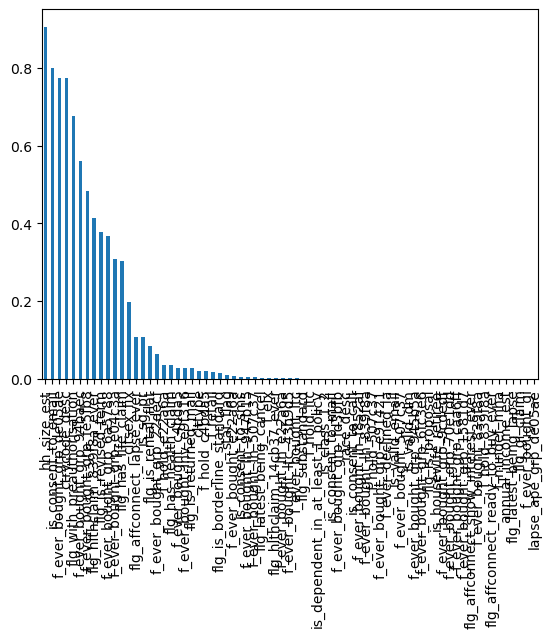

In [19]:
#Chi squared test
chi_scores = chi2(df_cat,y_train)

p_values = pd.Series(chi_scores[1],index = df_cat.columns)
p_values.sort_values(ascending = False , inplace = True)

p_values.plot.bar()

#features whose p_value is lower than 0.05 has high significance so we keep them
final_cat_col= p_values[p_values<0.05].index

In [20]:
final_cat_col
new_nom_col=[]
for i in named_nom_col:
  if i in final_cat_col:
    new_nom_col.append(i)
new_nom_col

['race_desc', 'clttype', 'stat_flag']

Feature 0: 13.835740
Feature 1: 12.145242
Feature 2: 2.466655
Feature 3: 122.803920
Feature 4: 32.161779
Feature 5: 8.752116
Feature 6: 0.214503
Feature 7: 0.687897
Feature 8: 0.354234
Feature 9: 0.696486
Feature 10: 0.333343
Feature 11: 0.216444
Feature 12: 0.545296
Feature 13: 0.021628
Feature 14: 9.199697
Feature 15: 0.094843
Feature 16: 2.023124
Feature 17: 0.327778
Feature 18: 0.006987
Feature 19: 0.571776
Feature 20: 0.539212
Feature 21: 10.325570
Feature 22: 0.048391
Feature 23: 0.235613
Feature 24: 0.401538
Feature 25: 0.000009
Feature 26: 1.869757
Feature 27: 0.204432
Feature 28: 1.449318
Feature 29: 4.314967
Feature 30: 0.715743
Feature 31: 0.000014
Feature 32: 7.471581
Feature 33: 0.867291
Feature 34: 4.775479
Feature 35: 10.337242
Feature 36: 0.229070
Feature 37: 19.362223
Feature 38: 0.026923
Feature 39: 0.359606
Feature 40: 3.728828
Feature 41: 0.047305
Feature 42: 0.372302
Feature 43: 0.107525
Feature 44: 1.804447
Feature 45: 8.280919
Feature 46: 0.201452
Feature 47: 2.0

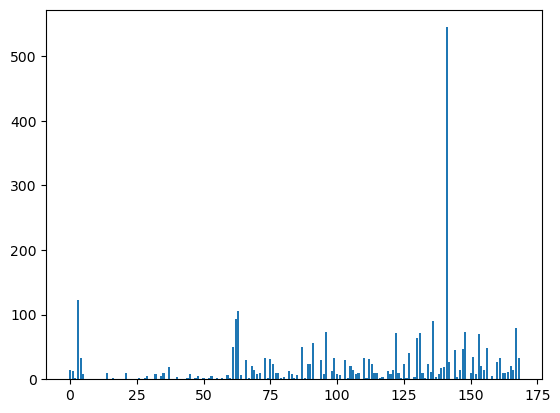

In [21]:
#ANOVA

# configure to select all features
fs = SelectKBest(score_func=f_classif, k='all')
# learn relationship from training data
fs.fit(df_num, y_train)


# what are scores for the features
for i in range(len(fs.scores_)):
 print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [22]:
#we will take the threshold of scores >20
num = len(fs.scores_[fs.scores_>20])
fs = SelectKBest(score_func=f_classif, k=num)
fs.fit(df_num, y_train)

cols_idxs = fs.get_support(indices=True)
df_num= df_num.iloc[:,cols_idxs]
final_num_col=df_num.columns

In [23]:
#X_train and X_test after feature selection
X_train= pd.concat([df_num,X_train[final_cat_col]],axis=1)
X_test=pd.concat([X_test[numerical].iloc[:,cols_idxs],X_test[final_cat_col]],axis=1)

In [24]:
#Helper method for onehotencode
def getfullitemsforOHE(wholedf,featlist,sort=True):
    """
    wholedf should be the dataframe including both train and test set.
    """
    def sortornot(X):
        if sort==False:
            return X
        else:
            return sorted(X)

    fulllist=[]
    for feat in featlist:
        fulllist.append(sortornot(wholedf[feat].unique()))
    return fulllist

In [25]:
cats= getfullitemsforOHE(df,new_nom_col)
cats

[['Chinese', 'Indian', 'Malay', 'Others'],
 ['C', 'G', 'P'],
 ['ACTIVE', 'LAPSED', 'MATURED']]

In [26]:
#Lets one hot encode the nominal cols
ohe=OneHotEncoder(categories=cats, sparse=False,handle_unknown="ignore")
X_trans=ohe.fit_transform(X_train[new_nom_col])
X_test_trans= ohe.transform(X_test[new_nom_col])
#let's present them in a dataframe
X_train_trans=pd.DataFrame(X_trans,columns=ohe.get_feature_names_out(new_nom_col), index= X_train.index)
X_test_trans=pd.DataFrame(X_test_trans,columns=ohe.get_feature_names_out(new_nom_col),index=X_test.index)

#Time to consolidate the whole data sets
X_train= pd.merge(X_train_trans, X_train.drop(columns=new_nom_col),left_index=True, right_index=True)
X_test=pd.merge(X_test_trans, X_test.drop(columns=new_nom_col),left_index=True, right_index=True)

/Users/cleo/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [27]:
trans_col_name=ohe.get_feature_names_out(new_nom_col)
trans_col_name

array(['race_desc_Chinese', 'race_desc_Indian', 'race_desc_Malay',
       'race_desc_Others', 'clttype_C', 'clttype_G', 'clttype_P',
       'stat_flag_ACTIVE', 'stat_flag_LAPSED', 'stat_flag_MATURED'],
      dtype=object)

In [28]:
#to save the relevant df into df_relevant
df_relevant = pd.merge(X_train,y_train,left_index=True, right_index=True)

final_cat_col2 = final_cat_col
final_cat_col=final_cat_col.drop(['race_desc','clttype','stat_flag'])
final_col_name =final_cat_col.append(pd.Index(trans_col_name))
new_lis=[df_relevant.columns.get_loc(c) for c in final_col_name]


In [29]:
# over sample (SMOTE) minority, then under sample majority
over = SMOTENC(categorical_features=new_lis, random_state=0,sampling_strategy=0.1) # oversample minority to have 10% of majority
under = RandomUnderSampler(sampling_strategy =0.4) # undersample to reduce majority
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps = steps)

X_train_resampled, y_train_resampled= pipeline.fit_resample(X_train, y_train)
y_train_resampled.value_counts()


0.0    3235
1.0    1294
Name: f_purchase_lh, dtype: int64

## Part 3 Data Modelling

In [30]:
# Neural Network
# Normalising data for NN
norm_X_train_resampled=(X_train_resampled[final_num_col]-X_train_resampled[final_num_col].mean())/X_train_resampled[final_num_col].std()
norm_X_train_resampled = pd.merge(X_train_resampled[final_col_name],norm_X_train_resampled,left_index=True, right_index=True)
norm_X_test =(X_test[final_num_col]-X_test[final_num_col].mean())/X_test[final_num_col].std()
norm_X_test = pd.merge(X_test[final_col_name],norm_X_test,left_index=True, right_index=True)
count=0

norm_X_train_resampled=np.asarray(norm_X_train_resampled).astype(np.float32)
y_train_resampled=np.asarray(y_train_resampled).astype(np.float32)
norm_X_test=np.asarray(norm_X_test).astype(np.float32)
y_test=np.asarray(y_test).astype(np.float32)

train accuracy:  0.8827555751821594
val accuracy:  0.9371937639198218
0.6586162604975405


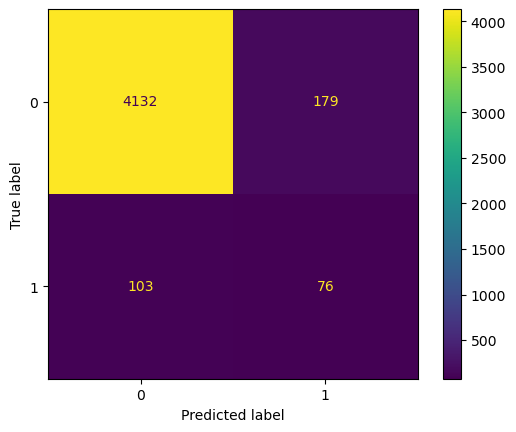

In [31]:
# gradient boosting
boosted_model = GradientBoostingClassifier()
boosted_model.fit(X_train_resampled, y_train_resampled)

print("train accuracy: ", boosted_model.score(X_train_resampled, y_train_resampled))
print("val accuracy: ", boosted_model.score(X_test, y_test))

y_predicted = boosted_model.predict(X_test)

lol= f1_score(y_test,y_predicted, average = "macro")
print(lol)

cm = confusion_matrix(y_test, y_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [44]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 

All relevant code MUST be included in this function.'''
    df=hidden_data
    
    drop_row1= df.query("min_occ_date == 'None'")
    drop_row2= df.query("cltdob_fix == 'None'")

    y= pd.concat([drop_row1, drop_row2]).drop_duplicates().index
    df = df.drop(y)
    
    df['min_occ_date']=pd.to_datetime(df['min_occ_date'])
    df['cltdob_fix']=pd.to_datetime(df['cltdob_fix'])

    df['years passed']= 2024- df['min_occ_date'].dt.year
    df['age']= 2024- df['cltdob_fix'].dt.year

    df=df.drop(columns=['min_occ_date','cltdob_fix'])
    sum_ins_list=[i for i in df.columns if i.startswith('sumins')]
    prempaid_list=[i for i in df.columns if i.startswith('prempaid')]
    df['total_sumins']=df[sum_ins_list].sum(axis=1)
    df['total_prepaid']=df[prempaid_list].sum(axis=1)
    df=df[final_cat_col2.append(final_num_col)]
    
    new_col=ohe.fit_transform(df[new_nom_col])
    new_sub_df=pd.DataFrame(new_col,columns=ohe.get_feature_names_out(new_nom_col), index= df.index)

    df_new= pd.merge(new_sub_df, df.drop(columns=new_nom_col),left_index=True, right_index=True)
    
    y_predicted = boosted_model.predict(X_test)
    result = y_predicted.tolist()
    return result

##### Cell to check testing_hidden_data function

In [47]:
# This cell should output a list of predictions.
test_df = pd.read_parquet(filepath)
test_df = test_df.drop(columns=["f_purchase_lh"])
print(testing_hidden_data(test_df))

[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

/Users/cleo/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!